In [73]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.express as px
from sklearn.metrics import classification_report

In [74]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## import data

In [75]:
# load data, import path of file on google drive
df = pd.read_csv("/content/drive/MyDrive/train.csv")
# first 5 rows
df.head()
# 0 = real
# 1 = fake

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [76]:
# drop id and text
df.drop(['id','text'],axis=1,inplace=True)
df.head()

,title,author,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1


## data cleaning

In [77]:
# Check for Null Values
df.isnull().sum()

title      558
author    1957
label        0
dtype: int64

In [78]:
# Drop Null values
df = df.dropna()

In [79]:
# Check for Duplicated Values
df.duplicated().sum()

164

In [80]:
# Drop Duplicated Values
df = df.drop_duplicates(keep='first')

In [81]:
# Merge both Columns author and Title and Create New Column Content
df['content'] = df['author'] + ' ' + df['title'] 

In [82]:
df.head()

,title,author,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,1,Consortiumnews.com Why the Truth Might Get You...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1,Howard Portnoy Iranian woman jailed for fictio...


## data preprocessing

In [83]:
# Function for entire text transformation
ps = PorterStemmer() 
def stemming(content):
    # remove numerical values
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    # convert text to lower case
    stemmed_content = stemmed_content.lower()
    # tokenize the text
    stemmed_content = stemmed_content.split()
    # remove stopword
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [84]:
df['content'] = df['content'].apply(stemming)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18121 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    18121 non-null  object
 1   author   18121 non-null  object
 2   label    18121 non-null  int64 
 3   content  18121 non-null  object
dtypes: int64(1), object(3)
memory usage: 707.9+ KB


In [86]:
# Drop title author and old content column
df = df.drop(['title','author'],axis=1)
df.head()

,label,content
0,1,darrel lucu hous dem aid even see comey letter...
1,0,daniel j flynn flynn hillari clinton big woman...
2,1,consortiumnew com truth might get fire
3,1,jessica purkiss civilian kill singl us airstri...
4,1,howard portnoy iranian woman jail fiction unpu...


In [87]:
# number of characters, number of words
df['number_of_characters'] = df['content'].apply(lambda x:len(x))
df['number_of_words'] = df['content'].apply(lambda x:len(nltk.word_tokenize(x)))

In [88]:
df.head()

,label,content,number_of_characters,number_of_words
0,1,darrel lucu hous dem aid even see comey letter...,67,12
1,0,daniel j flynn flynn hillari clinton big woman...,62,10
2,1,consortiumnew com truth might get fire,38,6
3,1,jessica purkiss civilian kill singl us airstri...,56,8
4,1,howard portnoy iranian woman jail fiction unpu...,84,12


## Exploratory Data Analysis

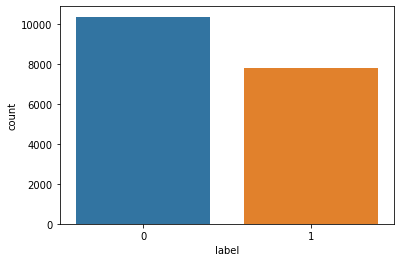

In [89]:
# Check Count of labels
sns.countplot(x='label',data=df)
# equal Distribution between Fake News and Real News
# no chance of bias

In [90]:
# statical info for the data
df[['number_of_characters','number_of_words']].describe()

,number_of_characters,number_of_words
count,18121.000000,18121.000000
mean,67.892059,11.056233
std,20.098124,3.243721
min,0.000000,0.000000
25%,56.000000,9.000000
50%,68.000000,11.000000
75%,79.000000,13.000000
max,330.000000,51.000000


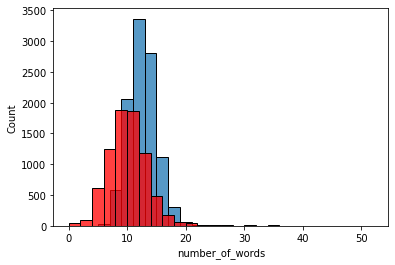

In [91]:
# histplot for Fake News words and True News words
sns.histplot(df['number_of_words'][df['label'] == 0],bins=50,binwidth=2)
sns.histplot(df['number_of_words'][df['label'] == 1],color='red',binwidth=2)

### wordcloud

In [92]:
# import wordcloud
from wordcloud import WordCloud

# make object of wordcloud
wc = WordCloud(background_color='white',min_font_size=10,width=500,height=500)

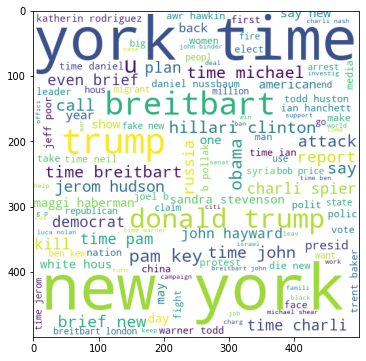

In [93]:
# True news
true_news_wc = wc.generate(df[df['label'] == 0]['content'].str.cat(sep=" "))
plt.figure(figsize=(8,6))
plt.imshow(true_news_wc)
plt.show()

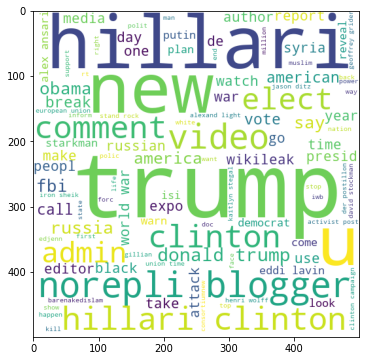

In [94]:
# Fake news
true_news_wc = wc.generate(df[df['label'] == 1]['content'].str.cat(sep=" "))
plt.figure(figsize=(8,6))
plt.imshow(true_news_wc)
plt.show()

### specific count of words

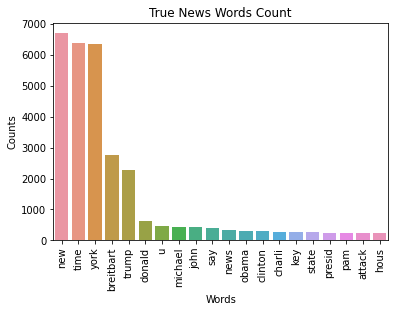

In [95]:
# library for Count Words
from collections import Counter

# create list of True News words
true_news_words_list = df[df['label']==0]['content'].str.cat(sep = " ").split()

# create DataFrame of that
true_news_words_df = pd.DataFrame(Counter(true_news_words_list).most_common(20))

# Plot barplot of this words
sns.barplot(x=true_news_words_df[0],y=true_news_words_df[1])
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('True News Words Count')
plt.show()

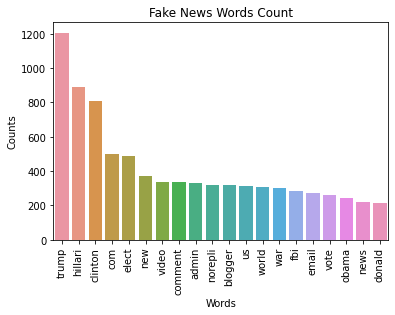

In [96]:
# library for Count Words
from collections import Counter

# create list of Fake News words
true_news_words_list = df[df['label']==1]['content'].str.cat(sep = " ").split()

# create DataFrame of that
true_news_words_df = pd.DataFrame(Counter(true_news_words_list).most_common(20))

# Plot barplot of this words
sns.barplot(x=true_news_words_df[0],y=true_news_words_df[1])
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Fake News Words Count')
plt.show()

#### we can see word that fake news contain mostly relate to politic. While True news does not contain too many of these word

In [97]:
# split the data
x = df['content'].values
y = df['label'].values

In [98]:
# convert text to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(x)
x = vectorizer.transform(x)

In [99]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.25,random_state=7,stratify=y)

## modeling

### Ordinal Logistic Regression

In [100]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [101]:
Y_pred = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_pred, Y_test)

In [102]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9823438534539837


In [103]:
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix 

array([[2527,   62],
       [  18, 1924]])

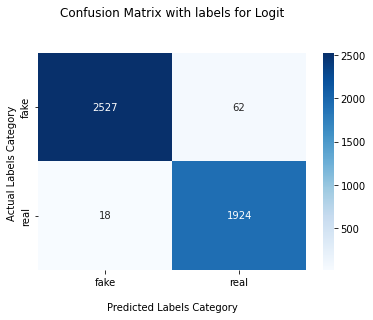

In [104]:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Confusion Matrix with labels for Logit\n\n');
ax.set_xlabel('\nPredicted Labels Category')
ax.set_ylabel('Actual Labels Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([ "fake","real"])
ax.yaxis.set_ticklabels(['fake',"real"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [105]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2589
           1       0.97      0.99      0.98      1942

    accuracy                           0.98      4531
   macro avg       0.98      0.98      0.98      4531
weighted avg       0.98      0.98      0.98      4531



### Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report

In [107]:
tree = DecisionTreeClassifier(random_state=1, criterion='gini')
tree = tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)

In [108]:
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix 

array([[2572,   17],
       [  31, 1911]])

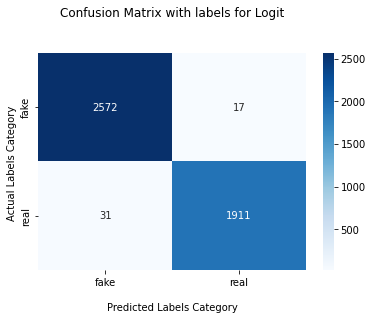

In [109]:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Confusion Matrix with labels for Logit\n\n');
ax.set_xlabel('\nPredicted Labels Category')
ax.set_ylabel('Actual Labels Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([ "fake","real"])
ax.yaxis.set_ticklabels(['fake',"real"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [110]:
tree.score(X_test, Y_test)

0.9894063120723902

In [111]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2589
           1       0.99      0.98      0.99      1942

    accuracy                           0.99      4531
   macro avg       0.99      0.99      0.99      4531
weighted avg       0.99      0.99      0.99      4531

